In [ ]:
# https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

**Download Kaggle dataset**





In [1]:
!pip install kaggle

In [4]:
import kaggle

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [6]:
api = KaggleApi()

In [7]:
api.authenticate()

In [12]:
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'test.tsv.zip', path='./')
api.competition_download_file('sentiment-analysis-on-movie-reviews', 'train.tsv.zip', path='./')

test.tsv.zip: Skipping, found more recently modified local copy (use --force to force download)


100%|██████████| 1.28M/1.28M [00:00<00:00, 6.88MB/s]

In [13]:
import zipfile

In [15]:
with zipfile.ZipFile('./test.tsv.zip', 'r') as zipref:
  zipref.extractall('./')

In [16]:
!pwd

/content


In [17]:
with zipfile.ZipFile('./train.tsv.zip', 'r') as zipref:
  zipref.extractall('./')

**Preprocessing dataset**

In [18]:
import pandas as pd

df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [19]:
len(df)

156060

<Axes: >

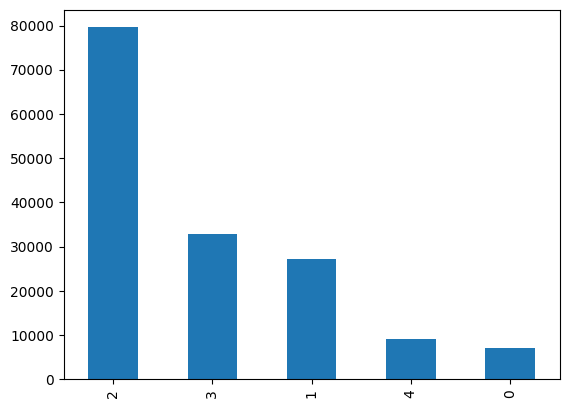

In [22]:
#df.drop_duplicates()
df['Sentiment'].value_counts().plot(kind='bar')

In [23]:
seq_len = 512
num_samples = len(df)

In [25]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 131.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.7 MB/s eta 0:00:00


In [27]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', return_tensors='np')

In [28]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [29]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [42]:
import numpy as np

with open('movie-xids.npy', 'wb') as f:
  np.save(f, tokens['input_ids'])

In [31]:

with open('movie-xmask.npy', 'wb') as f:
  np.save(f, tokens['attention_mask'])

In [32]:
arr = df['Sentiment'].values

In [35]:
# One hot encode
n_cols = arr.max()+1

n_rows = len(arr)
n_rows

156060

In [36]:
labels = np.zeros((n_rows, n_cols), dtype=int)
labels.shape

(156060, 5)

In [37]:
labels[np.arange(n_rows), arr] = 1
labels

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

In [38]:
with open('movie-labels.npy', 'wb') as f:
  np.save(f, labels)

**Pipeline building**

In [45]:
with open('movie-xids.npy', 'rb') as f:
  Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
  Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
  labels = np.load(f, allow_pickle=True)

In [46]:
Xids

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [47]:
labels

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

In [48]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [49]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.int64, name=None))>

In [53]:
def map_function(input_ids, masks, labels):
  return {'input_ids':input_ids, 'attention_masks':masks}, labels

In [54]:
dataset.map(map_function)

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_masks': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.int64, name=None))>

**Data processing**

In [58]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [59]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), TensorSpec(shape=(16, 5), dtype=tf.int64, name=None))>

In [61]:
split = 0.9
train_size = int(Xids.shape[0] / batch_size * split)

In [62]:
train_size

8778

In [64]:
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

In [66]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [67]:
train_ds.element_spec

(TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
 TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
 TensorSpec(shape=(16, 5), dtype=tf.int64, name=None))

In [68]:
val_ds.element_spec

(TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
 TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
 TensorSpec(shape=(16, 5), dtype=tf.int64, name=None))

In [69]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [71]:
ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), TensorSpec(shape=(16, 5), dtype=tf.int64, name=None))>

**Build and train**


In [72]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [73]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [111]:
import tensorflow as tf

# inputs
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int64')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int64')

# transformer
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

# classifier head
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)

y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [112]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False

In [113]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [118]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [120]:
element_spec=({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
               'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
              tf.TensorSpec(shape=(16, 5), dtype=tf.int64, name=None))

In [121]:
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

In [122]:
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.int64, name=None))>

In [123]:
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
  70/8778 [..............................] - ETA: 69:04:46 - loss: 1.2930 - accuracy: 0.5214

KeyboardInterrupt: ignored

**Prediction**

In [ ]:
def prep_data(text):

  tokens = tokenizer(text, max_length=512, truncation=True, padding='max_length', add_special_tokens=True, return_tensor='tf')

  return {'input_ids': tokens['input_ids'], 'attention_mask':tokens['attention_mask']}

In [ ]:
string_test = 'this movie was the shitties shit'

probs = model.predict(prep_data(string_test))[0]

In [ ]:
np.argmax(probs)